All_Beauty
Gesamt: 25000
Entfernt (<5 Wörter): 2774 (11.10%)
Verbleibend: 22226

Home_and_Kitchen
Gesamt: 25000
Entfernt (<5 Wörter): 1990 (7.96%)
Verbleibend: 23010

Tools_and_Home_Improvement
Gesamt: 25000
Entfernt (<5 Wörter): 2333 (9.33%)
Verbleibend: 22667


=== Übersicht: Kategorien & Split-Größen ===
                 Kategorie  Gesamt  Train  Test  Test-Anteil
                All_Beauty   25000  20000  5000          0.2
          Home_and_Kitchen   25000  20000  5000          0.2
Tools_and_Home_Improvement   25000  20000  5000          0.2

=== Verteilung der Ratings (Anzahl & Prozent) ===

-- Prozent (%) --
Rating                               1     2     3      4      5
Kategorie                  Split                                
All_Beauty                 Test   9.68  6.00  9.50  14.94  59.88
                           Train  9.68  6.00  9.50  14.95  59.87
Home_and_Kitchen           Test   5.40  3.36  7.12  16.10  68.02
                           Train  5.40  3.37  7.12  

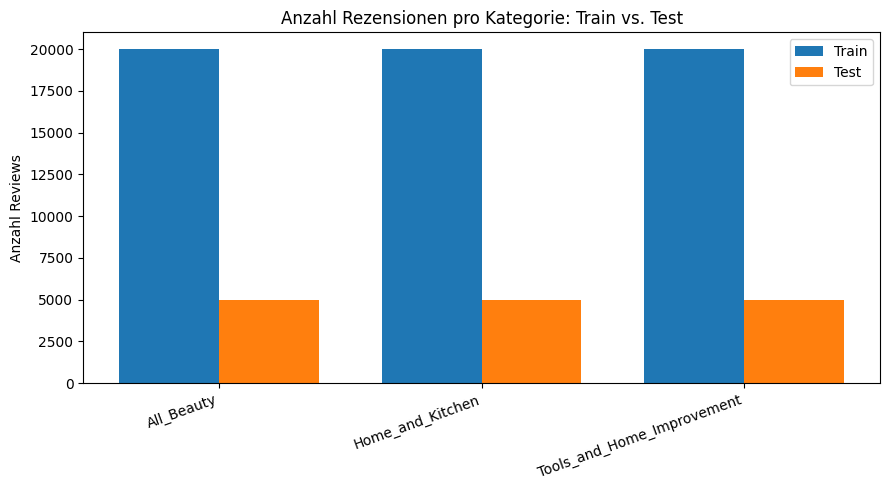

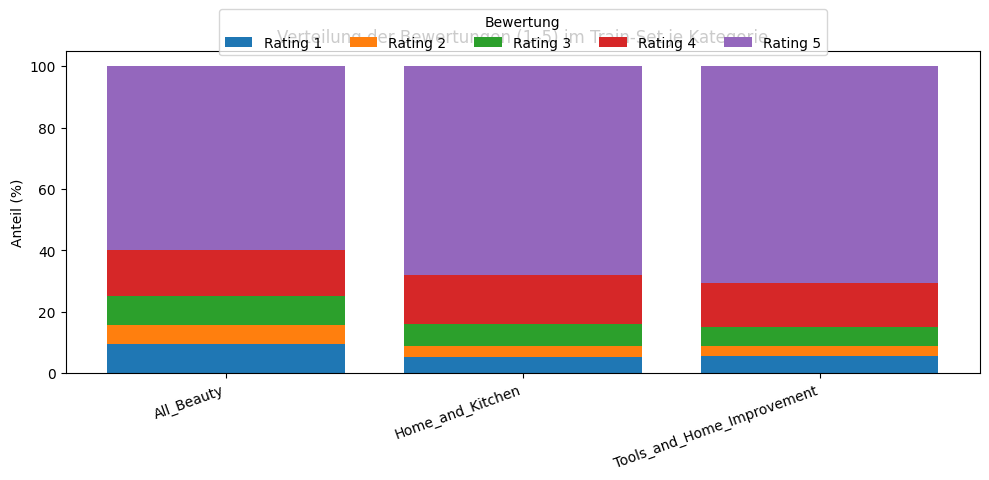

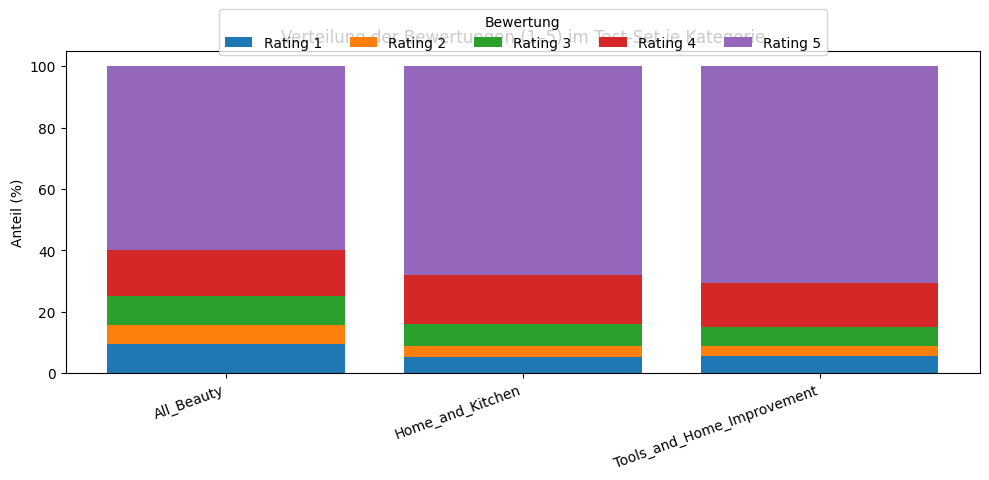

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import datasets

datasets.logging.set_verbosity_error()

CATEGORIES = ["All_Beauty", "Home_and_Kitchen", "Tools_and_Home_Improvement"]

def load_category(cat: str, split: str = "full", n: int | None = None) -> pd.DataFrame:
    """Lädt n Reviews einer Kategorie per Streaming und gibt ein DataFrame zurück."""

    ds = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_review_{cat}",
        split=split,
        streaming=True,
        trust_remote_code=True
    )

    if n is not None:
        ds = ds.take(n)

    rows = []
    for item in ds:
        rows.append({
            "rating": item["rating"],
            "text": item["text"],
            "title": item["title"],
        })

    return pd.DataFrame(rows)

dfs = {}
for cat in CATEGORIES:
    # Laden der Kategorien nacheinander und speichern im Dictionary
    dfs[cat] = load_category(cat, n=25_000)

    for cat, df in dfs.items():
        df["word_count"] = df["text"].fillna("").str.split().str.len()

for cat, df in dfs.items():
    total = len(df)
    removed = (df["word_count"] < 5).sum()
    remaining = (df["word_count"] >= 5).sum()
    percent = removed / total * 100

    print(cat)
    print(f"Gesamt: {total}")
    print(f"Entfernt (<5 Wörter): {removed} ({percent:.2f}%)")
    print(f"Verbleibend: {remaining}")
    print()

    import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 1) Hilfsfunktion: Split pro Kategorie + Statistiken ---
def split_and_describe(dfs: dict, test_size=0.2, random_state=42):
    summary_rows = []
    dist_rows = []

    for cat, df in dfs.items():
        df = df.copy()
        df["rating"] = df["rating"].astype(int)
        df["category"] = cat

        X = df[["category"]]          # Dummy-Features, wir brauchen nur den Split
        y = df["rating"]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            stratify=y,
            random_state=random_state
        )

        n_total = len(df)
        n_train = len(y_train)
        n_test  = len(y_test)

        summary_rows.append({
            "Kategorie": cat,
            "Gesamt": n_total,
            "Train": n_train,
            "Test": n_test,
            "Test-Anteil": n_test / n_total
        })

        # Verteilungen (Counts + Prozent) für Ratings 1..5
        for split_name, y_split in [("Train", y_train), ("Test", y_test)]:
            vc = y_split.value_counts().reindex([1,2,3,4,5], fill_value=0)
            vc_pct = (vc / vc.sum() * 100).round(2)

            for r in [1,2,3,4,5]:
                dist_rows.append({
                    "Kategorie": cat,
                    "Split": split_name,
                    "Rating": r,
                    "Anzahl": int(vc.loc[r]),
                    "Prozent": float(vc_pct.loc[r]),
                })

    summary_df = pd.DataFrame(summary_rows)
    dist_df = pd.DataFrame(dist_rows)

    return summary_df, dist_df

summary_df, dist_df = split_and_describe(dfs)

# --- 2) Tabellen ausgeben ---
print("\n=== Übersicht: Kategorien & Split-Größen ===")
print(summary_df.to_string(index=False))

print("\n=== Verteilung der Ratings (Anzahl & Prozent) ===")
# Pivot für kompakte Darstellung: pro Kategorie und Split die Prozentwerte je Rating
dist_pivot_pct = dist_df.pivot_table(
    index=["Kategorie", "Split"],
    columns="Rating",
    values="Prozent",
    aggfunc="sum"
).reindex(columns=[1,2,3,4,5])

dist_pivot_cnt = dist_df.pivot_table(
    index=["Kategorie", "Split"],
    columns="Rating",
    values="Anzahl",
    aggfunc="sum"
).reindex(columns=[1,2,3,4,5])

print("\n-- Prozent (%) --")
print(dist_pivot_pct.to_string())

print("\n-- Anzahl --")
print(dist_pivot_cnt.to_string())

# --- 3) Plot A: Train/Test-Anzahl pro Kategorie ---
plt.figure(figsize=(9,5))
x = np.arange(len(summary_df["Kategorie"]))
width = 0.38

plt.bar(x - width/2, summary_df["Train"], width, label="Train")
plt.bar(x + width/2, summary_df["Test"],  width, label="Test")

plt.xticks(x, summary_df["Kategorie"], rotation=20, ha="right")
plt.ylabel("Anzahl Reviews")
plt.title("Anzahl Rezensionen pro Kategorie: Train vs. Test")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4) Plot B: Rating-Verteilung (gestapelte Balken) pro Kategorie, getrennt für Train und Test ---
def plot_stacked_distribution(dist_df, split_name):
    df_split = dist_df[dist_df["Split"] == split_name].copy()
    pivot = df_split.pivot_table(
        index="Kategorie",
        columns="Rating",
        values="Prozent",
        aggfunc="sum"
    ).reindex(columns=[1,2,3,4,5]).fillna(0)

    plt.figure(figsize=(10,5))
    bottom = np.zeros(len(pivot.index))

    for r in [1,2,3,4,5]:
        vals = pivot[r].values
        plt.bar(pivot.index, vals, bottom=bottom, label=f"Rating {r}")
        bottom += vals

    plt.ylabel("Anteil (%)")
    plt.title(f"Verteilung der Bewertungen (1–5) im {split_name}-Set je Kategorie")
    plt.xticks(rotation=20, ha="right")
    plt.legend(title="Bewertung", ncols=5, bbox_to_anchor=(0.5, 1.15), loc="upper center")
    plt.tight_layout()
    plt.show()

plot_stacked_distribution(dist_df, "Train")
plot_stacked_distribution(dist_df, "Test")
